In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import yaml
import sys
import subprocess
import math

## Parallel focusing 
function which looks for the best setup of magnets to focus beam with some input parameters (energy and other initial parameters) into a parallel focused beam. The setup of magnets consists of 3 permanent quadrupole magnets which are positioned one after another. Because they are permanent, the only varying parameters are the distances between them. Function RefParticles() runs only 5 reference particles, Beam() function runs the whole beam.

In [6]:
fileName = "parallelBeam"
fillNumber = "001"
setupLength = 2 #m
longitudalEnergy = "5.0E+8" #eV
nIntervals = 10


#parameters of magnets 
lengthQ1 = 0.036  #m
lengthQ2 = 0.12  #m
lengthQ3 = 0.1  #m

boreQ1 = 0.007
boreQ2 = 0.018
boreQ3 = 0.030

#offsets and angles for reference particles
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV


#input parameters of the beam
nParticles = "500"
sig_x=0.75E0  #gaussian distribution in x direction with this sigma
sig_y=0.75E0
sig_px = 0.075E0
sig_py = 0.075E0




Files test0.ini all the way to test4.ini are input data for 5 different runs. File test0.ini has 0. reference particle with 0 offset and 0 initial angle, 1 and 2 have offsets in the x and y directions respectively and the last 2 have predefined angles. All of them should be parallel in the end.

In [7]:
def changeInputData(tag, newVar):
#universal function which changes input parameter in input file to Astra
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = " " + tag + "=" + newVar + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


    return

In [8]:
def update():
    
    inputData = "  " + xoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test1.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  " + yoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test2.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00 " + xmom + " 0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test3.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00 " + ymom + " 5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test4.ini", "w") as file:
        file.write(inputData)   

    #change input energy
    changeInputData("Ref_Ekin", longitudalEnergy)
    changeInputData("ZSTOP", str(setupLength) )

    #change properties of magnets
    changeInputData("Q_length(1)", str(lengthQ1))
    changeInputData("Q_length(2)", str(lengthQ2))
    changeInputData("Q_length(3)", str(lengthQ3))

    changeInputData("Q_bore(1)", str(boreQ1))
    changeInputData("Q_bore(2)", str(boreQ2))
    changeInputData("Q_bore(3)", str(boreQ3))
    
    #change parameters of the beam
    changeInputData("IPart", str(nParticles))

    changeInputData("sig_x", str(sig_x))
    changeInputData("sig_y", str(sig_y))
    changeInputData("sig_px", str(sig_px))
    changeInputData("sig_py", str(sig_py))

    
    print(f"Succesfully updated all variables.")

    return

In [9]:
def differLine(line):
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [10]:
def loadDataRef():
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    data = []
    with open(fileName + ".ref." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [11]:
def isRef0Straight(px, py):
    if px == 0 and py == 0:
        return True
    else:
        return False

In [12]:
def runRef(D1, D2, D3, moreData):
    #this function runs Astra 5 times with 5 different reference particles for specific D1,D2,D3

    
    Q1pos = D1 + lengthQ1/2 + 3*boreQ1
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2 + 6*boreQ1 + 3*boreQ2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2 + 6*boreQ1 + 6*boreQ2 + 3*boreQ3

    changeInputData("Q_pos(1)",str(Q1pos))
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )

    inputDataName = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]

    outputData = []
    for i in range(5):
        changeInputData("Distribution", inputDataName[i] )
        subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " >> output.txt", shell=True,check=True,executable='/bin/bash' )
        currentData = loadDataRef()
        #condition for 0. ref particle-> it cannot move
        if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
            print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
            return 1
            
        #condition to check if the particle came all the way to the end
        distFromEnd = math.fabs(currentData[-1][0] - setupLength)
        if distFromEnd > 0.1:
            print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
            return 1
        
        if moreData:
            outputData.append(currentData)
        else:
            outputData.append(currentData[-1]) # only save info about the ref particle at last z position
        

    return outputData

In [13]:
def angleCalculation(data):
#calculate angle of particles in mrad and sum up x and y direction in squares
    sum = 0
    for line in data: 
        sum += math.sqrt( (line[7]/line[2])**2 + (line[8]/line[2])**8)

    return sum

In [14]:
def RefParticles():

    update()

    #3 different variables- D1, D2, D3
    D1 = []
    D2 = []
    D3 = []

    #1/4 of the setup length will be divided into nIntervals
    interval = setupLength/(5*nIntervals)
    
    for i in range(nIntervals):
        D1.append(i*interval)
        D2.append(i*interval)
        D3.append(i*interval)


    bestD = [1,2,3] 
    minSum = 1e+7 #initial guess of sum of angles in x,y directions
    
    #3 cycles which run through all ranges of D1, D2, D3
    for D1_current in D1:
        print(f"Running D1 = '{D1_current}'... ")
        for D2_current in D2:
            for D3_current in D3:
                dataCurrent = runRef(D1_current, D2_current, D3_current, False)
                if dataCurrent == 1:
                    continue
                sum = angleCalculation(dataCurrent)
                #print(f"Momentum sum: '{momSum}'.")
                if sum <= minSum:
                    minSum = sum
                    bestD = {D1_current, D2_current, D3_current}
                    #print(f"Found a new temporary best setup with D1 = '{D1_current}', D2 = '{D2_current}', D3 = '{D3_current}'")

        print(f"finished it")
    
    print(f"Finished loop")

    return bestD

In [15]:
def separateDataXYZ(data):

    z0 = []
    x0 = []
    y0 = []
    for element in data:
        z0.append(element[0])
        x0.append(element[5])
        y0.append(element[6])
        
    XYZ = []
    XYZ.append(x0)
    XYZ.append(y0)
    XYZ.append(z0)
    
    return XYZ

In [16]:
def plotRefXY(D1, D2, D3):

    print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, True)

    data0 = separateDataXYZ(dataBest[0])
    data1 = separateDataXYZ(dataBest[1])
    data2 = separateDataXYZ(dataBest[2])
    data3 = separateDataXYZ(dataBest[3])
    data4 = separateDataXYZ(dataBest[4])


    plt.plot(data0[2], data0[0], label='0 offset, 0 angle', color='blue')
    plt.plot(data1[2], data1[0], label='x offset, 0 angle', color='green')
    plt.plot(data2[2], data2[0], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[0], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("x_offset [mm]")
    plt.title("x offset along z")

    plt.show()


    
    plt.plot(data0[2], data0[1], label='0 offset, 0 angle', color='blue')
    plt.plot(data1[2], data1[1], label='x offset, 0 angle', color='green')
    plt.plot(data2[2], data2[1], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[1], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[1], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("y_offset [mm]")
    plt.title("y offset along z")

    
    return

Succesfully updated all variables.
Running D1 = '0.0'... 
finished it
Running D1 = '0.04'... 
finished it
Running D1 = '0.08'... 
finished it
Running D1 = '0.12'... 
finished it
Running D1 = '0.16'... 
finished it
Running D1 = '0.2'... 
finished it
Running D1 = '0.24'... 
finished it
Running D1 = '0.28'... 
finished it
Running D1 = '0.32'... 
finished it
Running D1 = '0.36'... 
finished it
Finished loop
Running best setup again to get full data.


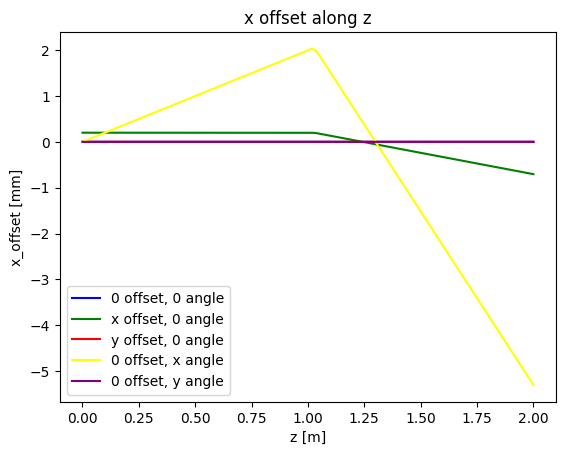

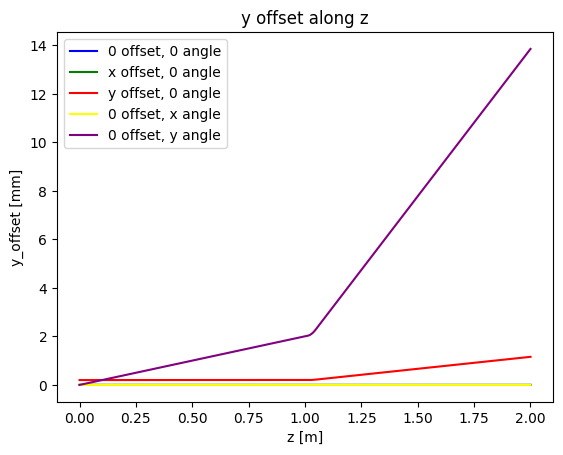

In [17]:
bestD = RefParticles()
plotRefXY(*bestD)   

In [22]:
def runBeam(D1,D2,D3, moreData):

    #change setup according to arguments  
    Q1pos = D1 + lengthQ1/2 + 3*boreQ1
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2 + 6*boreQ1 + 3*boreQ2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2 + 6*boreQ1 + 6*boreQ2 + 3*boreQ3

    changeInputData("Q_pos(1)",str(Q1pos))
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )

    

    
    subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName , shell=True,check=True,executable='/bin/bash' )

    #condition for 0. ref particle-> it cannot move
    with open(fileName + ".ref." + fillNumber,"r") as refFile:
        refData = refFile.readlines()
        
    if isRef0Straight(refData[-1][7], refData[-1][8]):
        print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
        return 1
            

    
    with open(fileName + ".Xemit." + fillNumber,"r") as fileX:
        xBeamData = fileX.readlines()

    xDivergence = xBeamData[-1][4]
        
    with open(fileName + ".Yemit." + fillNumber,"r") as fileY:
        yBeamData = fileY.readlines()

    yDivergence = yBeamData[-1][4]
    
    sum = math.sqrt( xDivergence**2 + yDivergence**2)


    return sum

In [23]:
def Beam():
# function which each setup runs only once and looks at the outcome of all 
    update()

    #3 different variables- D1, D2, D3
    D1 = []
    D2 = []
    D3 = []

    #1/4 of the setup length will be divided into nIntervals
    interval = setupLength/(5*nIntervals)
    
    for i in range(nIntervals):
        D1.append(i*interval)
        D2.append(i*interval)
        D3.append(i*interval)
    
    bestD = [1,2,3] 
    minSum = 1e+7 #initial guess of sum of angles in x,y directions
    
    #3 cycles which run through all ranges of D1, D2, D3
    for D1_current in D1:
        print(f"Running D1 = '{D1_current}'... ")
        for D2_current in D2:
            for D3_current in D3:
                sum = runBeam(D1_current, D2_current, D3_current, False)
                if sum == 1:
                    continue
                #print(f"Momentum sum: '{momSum}'.")
                if sum <= minSum:
                    minSum = sum
                    bestD = {D1_current, D2_current, D3_current}
                    #print(f"Found a new temporary best setup with D1 = '{D1_current}', D2 = '{D2_current}', D3 = '{D3_current}'")

        print(f"finished it")
    
    print(f"Finished loop for beam")

    return bestD


In [24]:
Beam()

Succesfully updated all variables.
Running D1 = '0.0'... 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         23. 8.2024  17:54

     Parameter file is:  parallelBeam.in                                   
     Example of ASTRA users manual                                                   

 Initialize element settings:
     neglecting space charge forces 

 --------------------------------------------------------------------------
 Quadrupole:

     quadrupole no.:        1         at =   2.8500E-02 m
     quadrupole no.:        2         at =   0.1440     m
     quadrupole no.:        3         at =   0.3260     m
 --------------------------------------------------------------------------
       1 particles from file test4.ini                                         

 

IndexError: list index out of range